# Diffusion Curves
## There's a detailed description in the PDF report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import triangle as tr
import igl
import meshplot as mp
import scipy.sparse as sp
from sksparse.cholmod import cholesky
from scipy.spatial.transform import Rotation

## Create / Load Data
- A geometric curve : cubic Bezier Spline
- Several colors on both sides

In [2]:
# x-y range of the image
xmax = 2.0
xmin = 0.0
ymax = 2.0
ymin = 0.0
vmin = np.array([xmin, ymin])
vmax = np.array([xmax, ymax])
xrange = xmax - xmin
yrange = ymax - ymin
sample_num = 51
# distance of left/right color curve to original curve
small_dist = xrange/100

### Bezier Curve

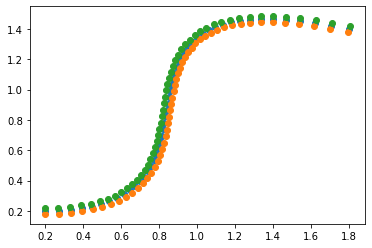

In [3]:
def cubic_bezier(_t, _v0, _v1, _v2, _v3):
    point = pow(1-_t, 3)*_v0 + 3*(1-_t)*(1-_t)*_t*_v1 + 3*(1-_t)*_t*_t*_v2 + pow(_t,3)*_v3
    derivative = 3*(1-_t)*(1-_t)*(_v1-_v0) + 6*(1-_t)*_t*(_v2-_v1) + 3*_t*_t*(_v3-_v2)
    # normalize
    tangent = derivative / np.linalg.norm(derivative)
    # rotate by 90 clockwise
    # (x,y) -> (-y, x)
    normal = np.array([-tangent[1], tangent[0]])   
    return point, normal
    
# def create_cubic_bezier_spline_data():
#     v0 = vmin + np.array([dx*0.1, dy*0.1])
#     v1 = vmin + np.array([dx*0.7, dy*0.1])
#     v2 = vmin + np.array([dx*0.1, dy*0.9])
#     v3 = vmin + np.array([dx*0.9, dy*0.7])
# #     vs = np.array([v0, v1, v2, v3])
# #     plt.plot(vs[:,0],vs[:,1])
#     vertices = []
#     for i in range(20):
#         vertices.append(cubic_bezier(i/20.0, v0, v1, v2, v3))
#     vertices = np.array(vertices)
#     plt.scatter(vertices[:,0],vertices[:,1])
# create_cubic_bezier_spline_data()

v0 = vmin + np.array([xrange*0.1, yrange*0.1])
v1 = vmin + np.array([xrange*0.7, yrange*0.1])
v2 = vmin + np.array([xrange*0.1, yrange*0.9])
v3 = vmin + np.array([xrange*0.9, yrange*0.7])
curve_vertices = []
# left/right curves (color sources)
curve_left_vertices = []
curve_right_vertices = []
curve_normals = []
# delta t
sample_interval = 1/float(sample_num-1)
for i in range(sample_num):
    v, normal = cubic_bezier(i*sample_interval, v0, v1, v2, v3)
    v_left = v - small_dist * normal
    v_right = v + small_dist * normal
    curve_vertices.append(v)
    curve_left_vertices.append(v_left)
    curve_right_vertices.append(v_right)
    curve_normals.append(normal)
    
curve_vertices = np.array(curve_vertices)
curve_left_vertices = np.array(curve_left_vertices)
curve_right_vertices = np.array(curve_right_vertices)
plt.scatter(curve_vertices[:,0],curve_vertices[:,1])
plt.scatter(curve_left_vertices[:,0],curve_left_vertices[:,1])
plt.scatter(curve_right_vertices[:,0],curve_right_vertices[:,1])

### Color Sources

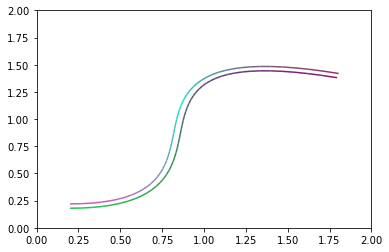

In [4]:
# color constraints on the left, each element is [r,g,b,t]
# assume intervals (t1-t2) of any two constraints is greater than sample integrals
cls_raw = np.array([[0.1,0.8,0.3,0.0],[0.5,0.1,0.5,1.0]])
crs_raw = np.array([[0.9,0.3,0.7,0.0],[0.1,0.9,0.8,0.6],[0.6,0.2,0.4,1.0]])
cls_raw_colors = cls_raw[:,:3]
crs_raw_colors = crs_raw[:,:3]
cls_raw_ts = cls_raw[:,3]
crs_raw_ts = crs_raw[:,3]

# interpolate to get colors of sample points
# two iterators on raw colors
def get_sample_colors(_raw_colors, _raw_ts):
    raw_num = _raw_colors.shape[0]
    raw_i = 0
    raw_j = 1
    raw_ti = _raw_ts[raw_i]
    raw_tj = _raw_ts[raw_j]
    sample_colors = []
    for i in range(sample_num):
        t = i*sample_interval
        # t should be between ti and tj
        if(t>raw_tj - 0.0001 and raw_j < raw_num - 1):
            raw_j += 1
            raw_tj = _raw_ts[raw_j]
            raw_i += 1
            raw_ti = _raw_ts[raw_i]
        dti = t - raw_ti
        dtj = raw_tj - t
        x = dti/(dti+dtj)
        color = x*_raw_colors[raw_j] + (1-x)*_raw_colors[raw_i]
        sample_colors.append(color)
    return np.array(sample_colors)
        
curve_left_colors = get_sample_colors(cls_raw_colors, cls_raw_ts)
curve_right_colors = get_sample_colors(crs_raw_colors, crs_raw_ts)
curve_left_vertices_reshaped = curve_left_vertices.reshape(-1,1,2)
curve_left_segments = np.concatenate([curve_left_vertices_reshaped[:-1], curve_left_vertices_reshaped[1:]], axis=1)
curve_right_vertices_reshaped = curve_right_vertices.reshape(-1,1,2)
curve_right_segments = np.concatenate([curve_right_vertices_reshaped[:-1], curve_right_vertices_reshaped[1:]], axis=1)
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
curve_left_segments = LineCollection(curve_left_segments, colors=curve_left_colors[1:,:], linestyle='solid')
curve_right_segments = LineCollection(curve_right_segments, colors=curve_right_colors[1:,:], linestyle='solid')
ax.add_collection(curve_left_segments)
ax.add_collection(curve_right_segments)
# plt.scatter(curve_left_vertices[:,0],curve_left_vertices[:,1], c = curve_left_colors)
# plt.plot(curve_right_vertices[:,0],curve_right_vertices[:,1], color = curve_right_colors)    

### Gradients

In [5]:
# N*2*3 array, N numbers, 2D(x and y axis), RGB value
gradients = np.zeros((sample_num,2,3))
for i in range(sample_num):
    delta_color = curve_right_colors[i] - curve_left_colors[i]
    normal = curve_normals[i]
    # along x axis
    gradients[i][0] = normal[0]*delta_color
    # along y axis
    gradients[i][1] = normal[1]*delta_color

Text(0.5, 1.0, 'Gradient in y direction')

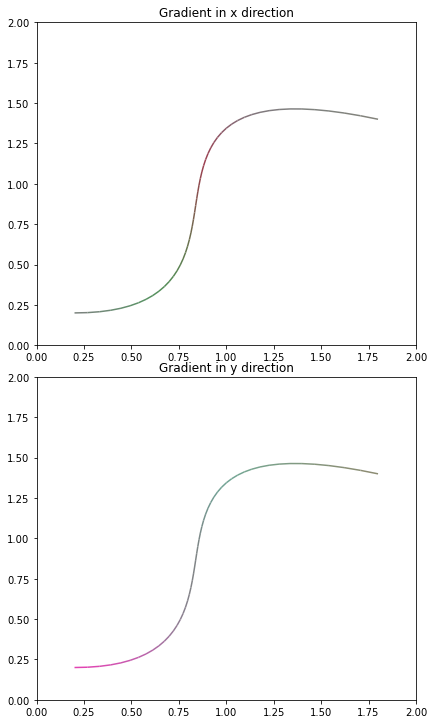

In [6]:
## To plot Gradient 
# map all elements to [0,1] (meet RGB requirements)
gradient_vals = 0.5* (gradients + 1) 
# color_norm = plt.Normalize(gradient_vals.min(), gradient_vals.max())
curve_vertices_reshaped = curve_vertices.reshape(-1,1,2)
curve_segments = np.concatenate([curve_vertices_reshaped[:-1], curve_vertices_reshaped[1:]], axis=1)
fig, (ax1, ax2) = plt.subplots(2, figsize=(6,10))
# plt.gca().set_aspect('equal', adjustable='box')
fig.tight_layout()
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
curve_gradx_segments = LineCollection(curve_segments, colors=gradient_vals[1:,0,:], linestyle='solid')
ax1.add_collection(curve_gradx_segments)
ax1.set_title("Gradient in x direction")
# ax = fig.add_subplot(2,1,2)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
curve_grady_segments = LineCollection(curve_segments, colors=gradient_vals[1:,1,:], linestyle='solid')
ax2.add_collection(curve_grady_segments)
ax2.set_title("Gradient in y direction")
# plt.axis('scaled')

## Triangle Meshes

In [7]:
# original mesh points:  gradient points, color points (left/right curve), boundary points
gradient_points = curve_vertices
gradient_constrs = gradients
gradient_constr_num = gradient_constrs.shape[0]
color_points = np.concatenate((curve_left_vertices, curve_right_vertices), axis = 0)
color_constrs = np.concatenate((curve_left_colors, curve_right_colors), axis = 0)
color_constr_num = color_constrs.shape[0]
bound_points = np.array([[xmin,ymin],[xmin,ymax],[xmax,ymin],[xmax,ymax]])
bound_vnum = bound_points.shape[0]
A = dict(vertices=np.concatenate((gradient_points, color_points, bound_points),axis=0))
B = tr.triangulate(A, 'qa0.02')
vertices = np.array(B['vertices'].tolist())
triangles = np.array(B['triangles'].tolist())
# tr.compare(plt, A, B)
# plt.show()
# print(color_constrs)
mp.plot(vertices, triangles, shading = {"flat":True, "wireframe":True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 1.0,…

## Diffusion

### Divergence

In [15]:
# (before averaging) d(w_t)/dx_t (tangent direction)
# (n-1)*3 matrix, n-1 segments, 3 for RGB
def calc_segment_divw():
    divs = np.zeros((gradient_constr_num -1, 3))
    for i in range(gradient_constr_num - 1):
        dx = gradient_points[i+1] - gradient_points[i]
        dx_len = np.linalg.norm(dx)
        # 2*3 array
        dw = gradient_constrs[i+1] - gradient_constrs[i] 
        divs[i,:] = (dx[0]*dw[0] + dx[1]*dw[1])/(dx_len*dx_len)
    return divs

def calc_segment_divw_accelerate():
    dxs = gradient_points[1:,:] - gradient_points[:-1,:]
    dx_lens = np.linalg.norm(dxs, axis = 1)
    dx_lensqs = np.square(dx_lens)
    dx_lensqinvs = np.reciprocal(dx_lensqs)
    dw = gradient_constrs[1:,:,:] - gradient_constrs[:-1,:,:]
    dwdx = np.einsum('ijk,ij->ik', dw, dxs)
    divs = np.einsum('ij,i->ij', dwdx, dx_lensqinvs)
    return divs

divw0 = calc_segment_divw_accelerate()

# print(divw0)
# get averaged divergence of each point by averaging left segment and right segment
divergence_constr_num = gradient_constr_num
divergence_points = gradient_points
divergence_constrs = np.zeros((divergence_constr_num, 3))
divergence_constrs[0] = divw0[0]
divergence_constrs[divergence_constr_num - 1] = divw0[divergence_constr_num - 2]
for i in range(1, divergence_constr_num - 1):
    divergence_constrs[i] = (divw0[i-1]+divw0[i])/2
# print(divergence_constrs.shape)

### Poisson Equation

In [16]:
# number of all mesh points
vnum = vertices.shape[0]
cotmatrix = igl.cotmatrix(vertices, triangles)
massmatrix = igl.massmatrix(vertices, triangles, igl.MASSMATRIX_TYPE_VORONOI)
massinv = sp.diags(1 / massmatrix.diagonal())
# Laplacian matrix
L = massinv@cotmatrix
# Divergence matrix
D = np.zeros((vnum, 3))
D[:divergence_constr_num,:] = divergence_constrs
# LI = D with constraints

### Matrix Partitioning

In [17]:
# LxxIx = Dx - LxcIc
unknown_ids = np.concatenate((range(divergence_constr_num),range(divergence_constr_num + color_constr_num, vnum)), axis = 0)
constant_ids = np.array(range(divergence_constr_num, divergence_constr_num + color_constr_num))
Lxx = L[unknown_ids,:][:,unknown_ids]
Lxc = L[unknown_ids,:][:,constant_ids]
Dx = D[unknown_ids,:]

### Solve

In [18]:
Ix = sp.linalg.spsolve(Lxx, Dx - Lxc@color_constrs)

### Image with Diffused Color

In [19]:
I = np.zeros((vnum,3))
I[constant_ids,:] = color_constrs
I[unknown_ids, :] = Ix
mp.plot(vertices, triangles, c = I)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 1.0,…